# Planet

$\textbf{Data Source}$: 
Kaggle Planet: Understanding the Amazon from Space Competition https://www.kaggle.com/c/planet-understanding-the-amazon-from-space

$\textbf{Data Preparation}$:
To run this Jupyter Notebook, download data from Kaggle Website and then do the following steps: 
1. Unzip the file train_v2.csv.zip
2. Unpack train-jpg.tar.7z using following commands: <br>
   $ ~~ \texttt{7za x train-jpg.tar.7z} $ <br>
   $ ~~ \texttt{tar xf train-jpg.tar} $
3. Similarly, unpack test-jpg.tar.7z and test-jpg-additional.tar.7z. Then move all the images from the test-jpg-additional folder to the test-jpg folder.
4. Finally, place the labels file 'train_v2.csv' along with the image folders 'train-jpg' and 'test-jpg' into the 'Planet' directory of your cloned version of the NeuralNetworkLibrary repository.

$\textbf{Objective}$:
Multi-Label Image Classification. Images are satellite images of the Amazon Basin with labels concerning atmospheric conditions such as 'clear', 'cloudy', or 'haze' as well as land cover/land use labels such as 'agriculture', 'roads', or 'primary' (meaning primary rainforest). Each image has 1 or more atmospheric labels and 0 or more land use/land cover labels. The goal is to determine whether each image has each of the possible labels or not. 

In [1]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports
import sys
sys.path.append("../")
from Applications.Vision import *

### Look at the Data

First look at the images.

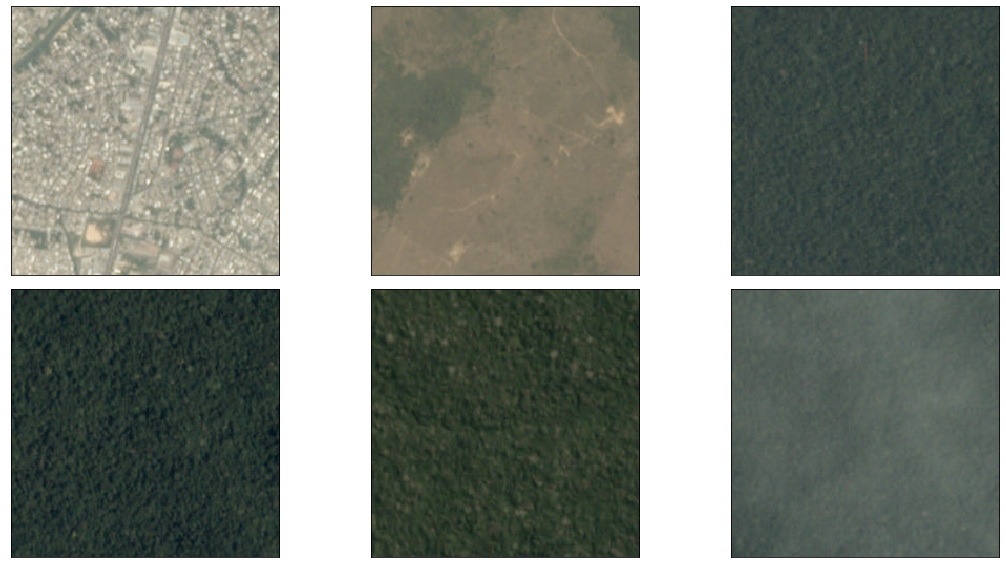

In [2]:
# Images chosen randomly from train folder
ShowImages_from_folder('Planet/train-jpg')

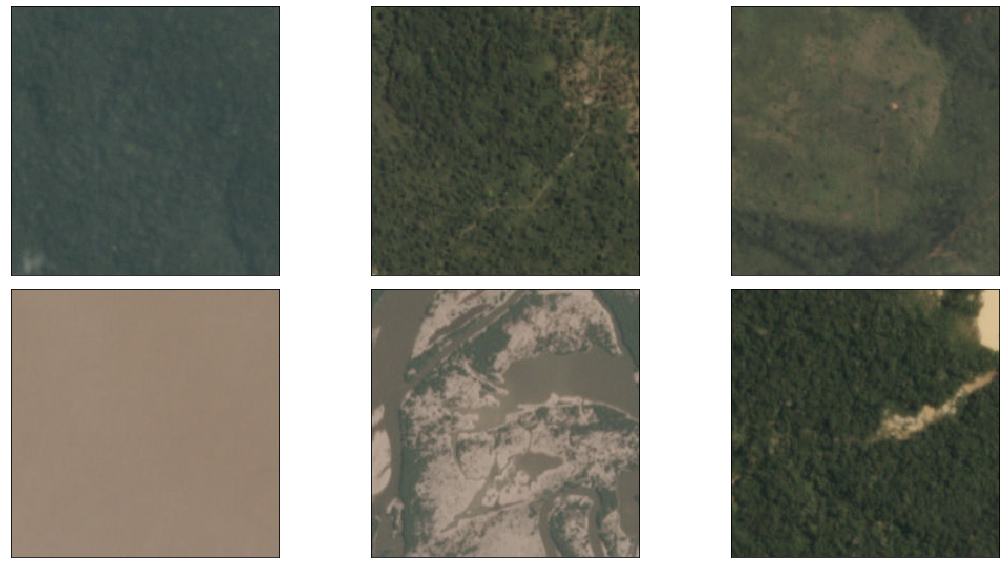

In [3]:
# Images chosen randomly from test folder
ShowImages_from_folder('Planet/test-jpg')

Now look at some basic properties of the dataset.

In [4]:
# red,green,blue means and stds (per pixel)
train_means, train_stds = get_stats('Planet/train-jpg')
test_means, test_stds = get_stats('Planet/test-jpg')

print('imagnet_means =',imagenet_stats[0], 'imagnet_stds =', imagenet_stats[1])
print('train_means =',np.round(train_means,3), 'train_stds =', np.round(train_stds,3))
print('test_means =',np.round(test_means,3), 'test_stds =', np.round(test_stds,3))


imagnet_means = [0.485 0.456 0.406] imagnet_stds = [0.229 0.224 0.225]
train_means = [0.315 0.345 0.303] train_stds = [0.167 0.144 0.137]
test_means = [0.315 0.344 0.302] test_stds = [0.167 0.144 0.138]


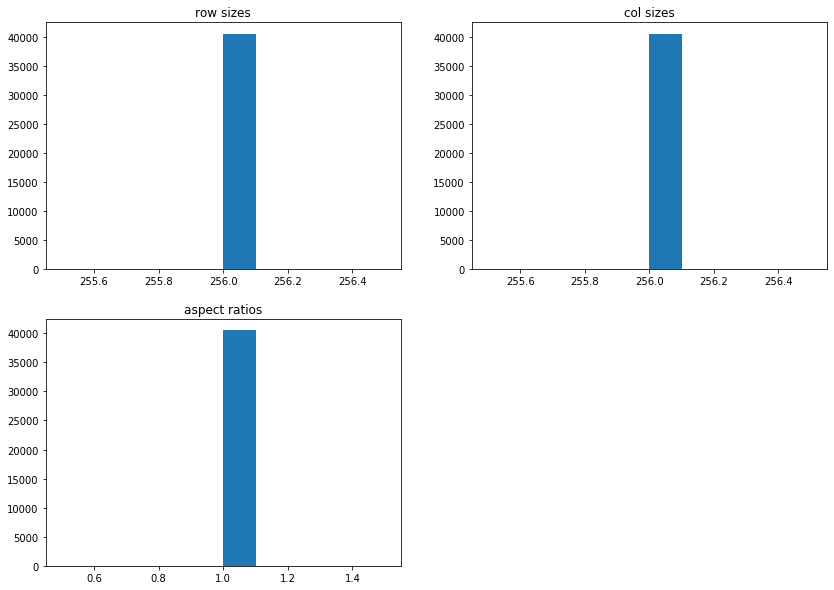

In [5]:
# Histograms of img shapes for train data
plot_imgsize_histograms('Planet/train-jpg')

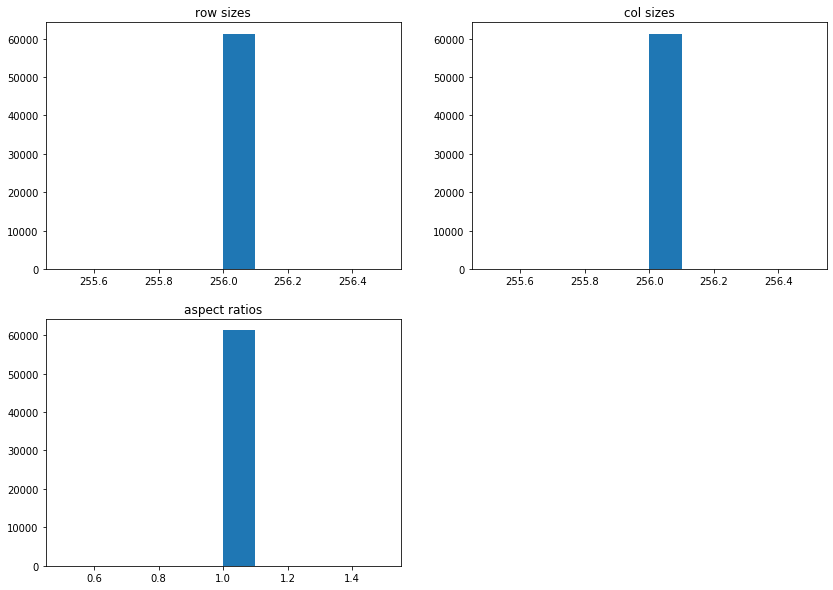

In [6]:
# Histograms of img shapes for test data
plot_imgsize_histograms('Planet/test-jpg')

Observations:

1. As expected, these satellite photos look very different from standard imagenet type images.
2. Red/Green/Blue means and stds of images are NOT very similar to imagenet.
3. Images are all of size 256 by 256 pixels, which is very nice.

So, overall, this is NOT really a standard image classification dataset. First of all it is multi-label, which makes things harder to begin with. Also, images look quite different from imagenet type photos and are often very dark. 

### Training

In light of the observations above, it is likely we will need to do significantly more re-training of the imagenet weights in the backbone architecture than normal. Thus, we will make the following changes to our standard training procedure when finetuning a pre-trained imagenet model:

1. We will start with small images resized to 64 by 64, then increase to 128 by 128, then finally increase to 256 by 256. This strategy will allow faster adaptation of the imagenet weights. 

2. When training with differential learning rates we will use [lr/9,lr/3,lr] instead of [lr/100,lr/10,lr]. That is, there will not be such a large difference in the learning rates used for earlier and later layers.

We will also use 'TopDown' augmentation transformations instead of 'SideOn', since the images are taken from above.

In [7]:
# f2 metric used for the kaggle competition, at different thresholds
f2_1 = fbeta_loss(2,threshold=0.1)
f2_2 = fbeta_loss(2,threshold=0.2)
f2_3 = fbeta_loss(2,threshold=0.3)
f2_4 = fbeta_loss(2,threshold=0.4)
f2_5 = fbeta_loss(2,threshold=0.5)

#### sz = 64

In [8]:
PATH = 'Planet'
transforms = get_transforms('TopDown',sz=64)
data = ImageDataObj.from_csv(PATH, transforms, bs=64, train_csv='train_v2.csv', train_name='train-jpg',
                             test_name='test-jpg', target_type='multi_label', suffix='.jpg')

In [9]:
arch = models.resnet34(pretrained=True)
model = ImageClassificationNet(data,arch)
learner = ImageLearner(PATH,data,model)

Look at some labeled images, just to see what labels are like.

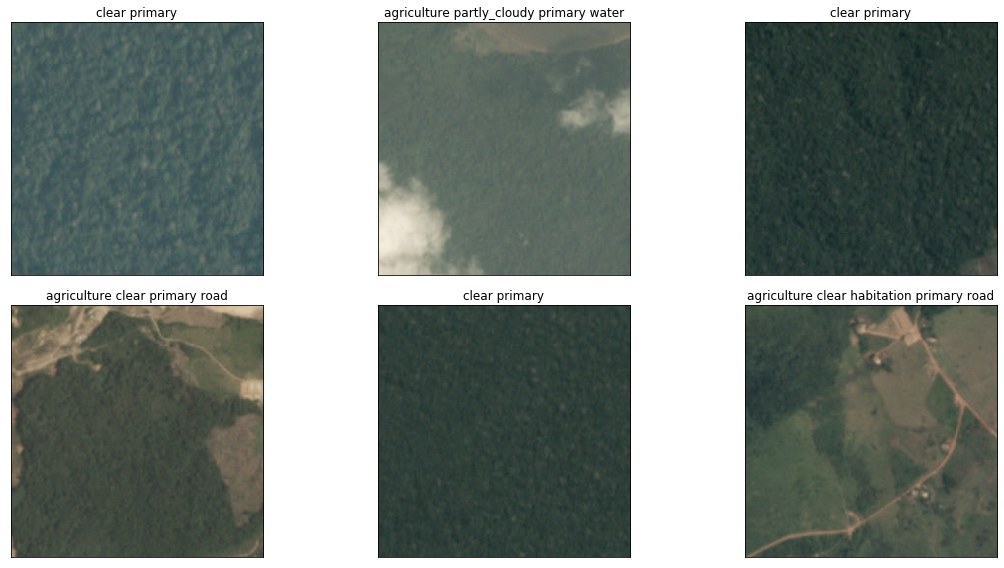

In [10]:
learner.show_images('train')

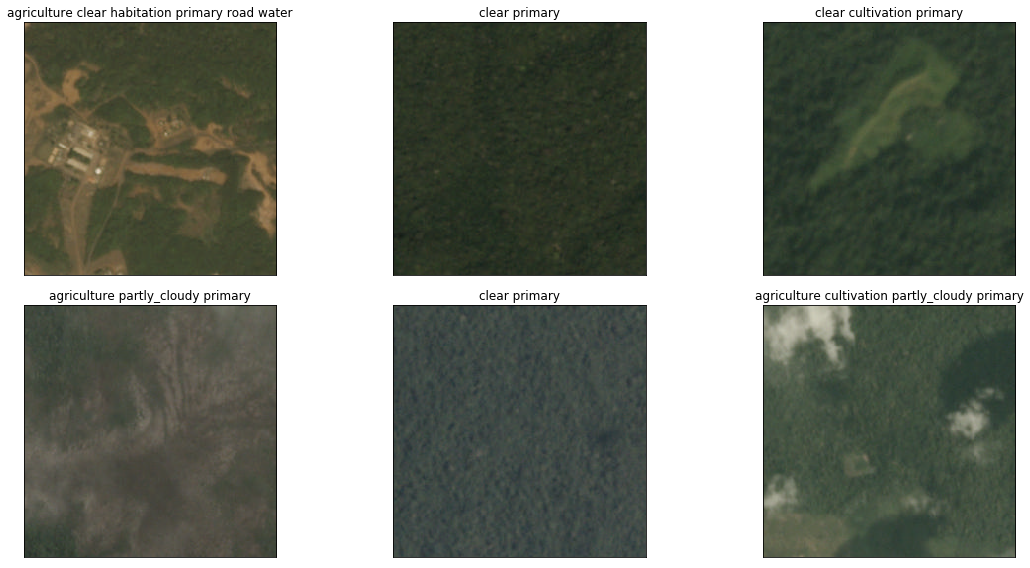

In [11]:
learner.show_images('val')

Begin training with backbone frozen.

In [12]:
learner.freeze()
learner.bn_freeze()

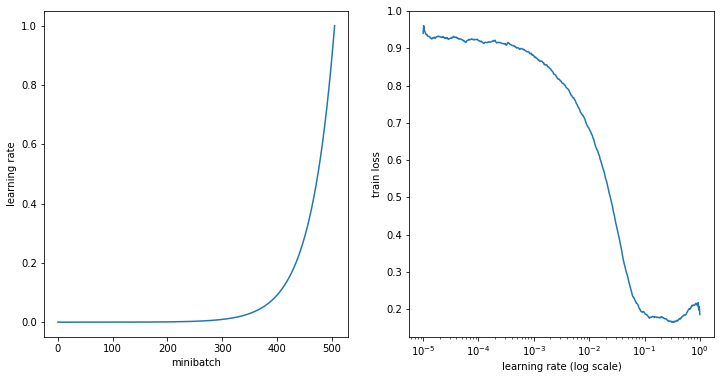

In [13]:
learner.find_lr()

In [14]:
lr = 0.1
learner.fit_cycles(lr,lr/100,num_cycles=3,cycle_mult=2,metrics=[f2_1,f2_2,f2_3,f2_4,f2_5])

epoch   train_loss  val_loss    accuracy    metrics     

0       0.14915     0.12735     0.95067     0.87280     0.88196     0.87703     0.86320     0.84293       epoch run time: 0 min, 15.73 sec
1       0.14137     0.12300     0.95201     0.87897     0.88798     0.88260     0.86938     0.85146       epoch run time: 0 min, 15.92 sec
2       0.13489     0.12039     0.95292     0.87711     0.88838     0.88527     0.87436     0.85558       epoch run time: 0 min, 15.63 sec
3       0.13932     0.12261     0.95197     0.87601     0.88857     0.88390     0.87234     0.85824       epoch run time: 0 min, 15.64 sec
4       0.13555     0.11856     0.95368     0.88109     0.89144     0.88559     0.87198     0.85399       epoch run time: 0 min, 16.21 sec
5       0.13051     0.11608     0.95488     0.88471     0.89412     0.88792     0.87557     0.85728       epoch run time: 0 min, 16.18 sec
6       0.12575     0.11572     0.95458     0.88314     0.89370     0.89091     0.87827     0.86093       ep

From output above we see that the 0.2 threshold (second metric) is good. So, we will only use this 
one in future training for cleaner display. Also, in the end when making our predictions for Kaggle submission 
we will threshold at 0.2.

Also, note that for multi-label classification problems accuracy is computed follows:

$\bullet$ accuracy(image j) = fraction of labels correctly predicted (yes or no) for image j

$\bullet$ accuracy = mean over all j of accuracy(image j)

In [15]:
f2 = fbeta_loss(2,threshold=0.2)

Now, unfreeze and continue training.

In [16]:
learner.unfreeze()
learner.bn_unfreeze()
lrs = [lr/9,lr/3,lr]
lrs_min = [lr/900,lr/300,lr/100]
learner.fit_cycles(lrs,lrs_min,num_cycles=3,cycle_mult=2,metrics=[f2],save_name='64')

epoch   train_loss  val_loss    accuracy    metrics     

0       0.11920     0.10670     0.95790     0.90499       epoch run time: 0 min, 24.28 sec
1       0.11040     0.10306     0.95939     0.90720       epoch run time: 0 min, 24.27 sec
2       0.10402     0.10033     0.96027     0.91115       epoch run time: 0 min, 24.48 sec
3       0.10913     0.10133     0.96014     0.90729       epoch run time: 0 min, 23.83 sec
4       0.10049     0.10181     0.96027     0.90831       epoch run time: 0 min, 23.96 sec
5       0.09905     0.09839     0.96090     0.91155       epoch run time: 0 min, 24.05 sec
6       0.09744     0.09911     0.96079     0.91096       epoch run time: 0 min, 23.90 sec


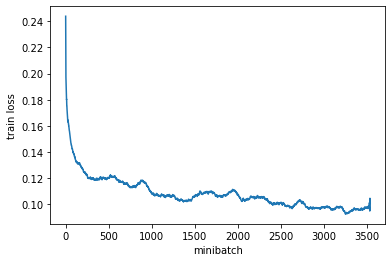

In [17]:
learner.plot_loss_sched(smoothing_radius=50)

#### sz = 128

In [18]:
learner.data_resize(128)
learner.freeze()
learner.bn_freeze()
learner.fit_cycles(lr,lr/100,num_cycles=3,cycle_mult=2,metrics=[f2])

epoch   train_loss  val_loss    accuracy    metrics     

0       0.09892     0.09613     0.96224     0.91255       epoch run time: 0 min, 22.51 sec
1       0.09869     0.09515     0.96303     0.91273       epoch run time: 0 min, 23.37 sec
2       0.09493     0.09347     0.96374     0.91487       epoch run time: 0 min, 22.43 sec
3       0.10136     0.09557     0.96271     0.91206       epoch run time: 0 min, 22.87 sec
4       0.09808     0.09383     0.96343     0.91358       epoch run time: 0 min, 22.16 sec
5       0.09374     0.09359     0.96355     0.91530       epoch run time: 0 min, 22.76 sec
6       0.09263     0.09377     0.96345     0.91435       epoch run time: 0 min, 23.52 sec


In [19]:
learner.unfreeze()
learner.bn_unfreeze()
learner.fit_cycles(lrs,lrs_min,num_cycles=3,cycle_mult=2,metrics=[f2],save_name='128')

epoch   train_loss  val_loss    accuracy    metrics     

0       0.09088     0.08791     0.96524     0.92148       epoch run time: 0 min, 39.14 sec
1       0.09471     0.08924     0.96500     0.91750       epoch run time: 0 min, 39.60 sec
2       0.09010     0.08652     0.96630     0.92149       epoch run time: 0 min, 39.15 sec
3       0.09520     0.08672     0.96612     0.92225       epoch run time: 0 min, 39.42 sec
4       0.08944     0.08618     0.96641     0.92290       epoch run time: 0 min, 39.32 sec
5       0.08772     0.08505     0.96658     0.92488       epoch run time: 0 min, 39.23 sec
6       0.08113     0.08489     0.96689     0.92510       epoch run time: 0 min, 39.23 sec


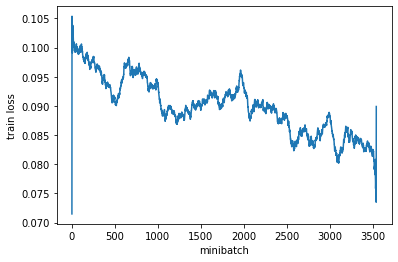

In [20]:
learner.plot_loss_sched(smoothing_radius=50)

#### sz = 256

In [21]:
learner.data_resize(256)
learner.freeze()
learner.bn_freeze()
learner.fit_cycles(lr,lr/100,num_cycles=3,cycle_mult=2,metrics=[f2])

epoch   train_loss  val_loss    accuracy    metrics     

0       0.09193     0.08713     0.96621     0.92095       epoch run time: 0 min, 55.75 sec
1       0.08946     0.08733     0.96580     0.92044       epoch run time: 0 min, 55.77 sec
2       0.08959     0.08538     0.96661     0.92279       epoch run time: 0 min, 55.95 sec
3       0.09210     0.08622     0.96634     0.92315       epoch run time: 0 min, 55.91 sec
4       0.08764     0.08617     0.96625     0.92302       epoch run time: 0 min, 55.74 sec
5       0.08582     0.08468     0.96702     0.92380       epoch run time: 0 min, 56.25 sec
6       0.08884     0.08503     0.96684     0.92294       epoch run time: 0 min, 56.20 sec


In [22]:
learner.unfreeze()
learner.bn_unfreeze()
learner.fit_cycles(lrs,lrs_min,num_cycles=3,cycle_mult=2,metrics=[f2],save_name='256')

epoch   train_loss  val_loss    accuracy    metrics     

0       0.08741     0.08170     0.96827     0.92712       epoch run time: 2 min, 0.81 sec
1       0.08804     0.08226     0.96779     0.92767       epoch run time: 2 min, 1.50 sec
2       0.08309     0.08013     0.96881     0.92960       epoch run time: 2 min, 1.37 sec
3       0.08729     0.08244     0.96747     0.92603       epoch run time: 2 min, 1.68 sec
4       0.08495     0.08058     0.96832     0.93038       epoch run time: 2 min, 1.57 sec
5       0.08075     0.08008     0.96864     0.92874       epoch run time: 2 min, 1.43 sec
6       0.07813     0.07976     0.96879     0.92987       epoch run time: 2 min, 1.42 sec


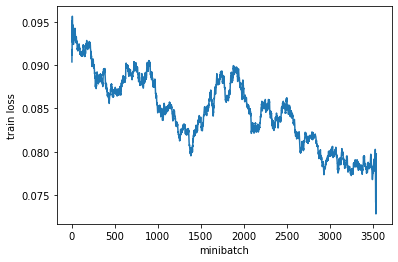

In [23]:
learner.plot_loss_sched(smoothing_radius=50)

#### Test Time Augmentation

In [24]:
# Alternate form of fbeta_loss, does not apply sigmoid and then thresholding to output of model. 
# Instead the predicted labels, 0 or 1 for each possible class, must be passed in directly. 
# This is needed since the test time augmentation procedure already applies sigmoid to 
# outputs of models before averaging them.

F2 = fbeta_loss(2,use_thresh=False)

In [25]:
# Do TTA for Val and Test Sets
predprobs_val, _ = learner.TTA('val')
predprobs_test, _ = learner.TTA('test')

In [26]:
# Validation f2 score
target = np.array(learner.data.val_ds.y)
f2_score = F2((TEN(predprobs_val) > 0.2).float(),TEN(target)).item()
print(f2_score)

0.9314685463905334


#### Kaggle Submission

In [27]:
tags = []
for i in range(len(predprobs_test)):
    tags_i = (predprobs_test[i] > 0.2).nonzero()[0]
    tags_i = [data.categories[x] for x in tags_i]
    tags_i = ' '.join(x for x in tags_i)
    tags.append(tags_i)
    
for i in range(5):
    print(tags[i])

agriculture cultivation partly_cloudy primary
agriculture clear cultivation habitation primary
agriculture clear primary road water
clear primary
partly_cloudy primary


In [28]:
image_names = os.listdir('Planet/test-jpg')
image_names = [image_name[:-4] for image_name in image_names] # to remove .jpg extension in names
print(len(image_names))
print(image_names[:5])

61191
['test_25202', 'test_5717', 'test_40598', 'file_2096', 'file_19729']


In [29]:
submission_df = pd.DataFrame({'image_name':image_names, 'tags':tags})
submission_df.to_csv('Planet/submission.csv',index=False)

In [30]:
submission = pd.read_csv('Planet/submission.csv')
submission

,image_name,tags
0,test_25202,agriculture cultivation partly_cloudy primary
1,test_5717,agriculture clear cultivation habitation primary
2,test_40598,agriculture clear primary road water
3,file_2096,clear primary
4,file_19729,partly_cloudy primary
5,file_423,agriculture clear cultivation haze primary
6,file_401,clear haze primary road water
7,test_35442,agriculture clear cultivation primary road water
8,file_7286,clear primary
9,test_22859,cloudy haze primary


This submission received a Kaggle Private Leader Board score of 0.92810, which would have been 129th place out of 938 teams in the competition.

### Ensembling

To improve our score we will now try an ensemble of 10 models, all trained with same procedure as above.

In [31]:
PATH = 'Planet'
lr = 0.1
lrs = [lr/9,lr/3,lr]
lrs_min = [lr/900,lr/300,lr/100]

val_f2scores, test_preds = [],[]

for i in range(10): 
    
    print('Model ' + str(i))
    transforms = get_transforms('TopDown',sz=64)
    data = ImageDataObj.from_csv(PATH, transforms, bs=64, train_csv='train_v2.csv', train_name='train-jpg',
                                 test_name='test-jpg', target_type='multi_label', suffix='.jpg')
    
    arch = models.resnet34(pretrained=True)
    model = ImageClassificationNet(data,arch)
    learner = ImageLearner(PATH,data,model)
    
    learner.freeze()
    learner.bn_freeze()
    learner.fit_cycles(lr,lr/100,num_cycles=3,cycle_mult=2,metrics=[f2])
    learner.unfreeze()
    learner.bn_unfreeze()
    learner.fit_cycles(lrs,lrs_min,num_cycles=3,cycle_mult=2,metrics=[f2])
    
    learner.data_resize(128)
    learner.freeze()
    learner.bn_freeze()
    learner.fit_cycles(lr,lr/100,num_cycles=3,cycle_mult=2,metrics=[f2])
    learner.unfreeze()
    learner.bn_unfreeze()
    learner.fit_cycles(lrs,lrs_min,num_cycles=3,cycle_mult=2,metrics=[f2])
    
    learner.data_resize(256)
    learner.freeze()
    learner.bn_freeze()
    learner.fit_cycles(lr,lr/100,num_cycles=3,cycle_mult=2,metrics=[f2])
    learner.unfreeze()
    learner.bn_unfreeze()
    learner.fit_cycles(lrs,lrs_min,num_cycles=3,cycle_mult=2,metrics=[f2],save_name='Model'+str(i))
    
    predprobs_val, _ = learner.TTA('val')
    target = np.array(learner.data.val_ds.y)
    f2_score = F2((TEN(predprobs_val) > 0.2).float(),TEN(target)).item()
    val_f2scores.append(f2_score)
    
    predprobs_test, _ = learner.TTA('test')
    test_preds.append(predprobs_test)
    
    clear_output()

Print out f2 score for each model

In [32]:
for i,score in enumerate(val_f2scores):
    print('Model ' + str(i) + ':', score)

Model 0: 0.9297351241111755
Model 1: 0.926462709903717
Model 2: 0.930613100528717
Model 3: 0.9310294389724731
Model 4: 0.9309885501861572
Model 5: 0.928138017654419
Model 6: 0.9286103248596191
Model 7: 0.9293485879898071
Model 8: 0.9290714859962463
Model 9: 0.9307820200920105


Create Kaggle Submission (using average of predicted probabilities from the 10 models)

In [33]:
predprobs_test = (1/10)*sum(test_preds) 

tags = []
for i in range(len(predprobs_test)):
    tags_i = (predprobs_test[i] > 0.2).nonzero()[0]
    tags_i = [data.categories[x] for x in tags_i]
    tags_i = ' '.join(x for x in tags_i)
    tags.append(tags_i)
    
image_names = os.listdir('Planet/test-jpg')
image_names = [image_name[:-4] for image_name in image_names]

submission2_df = pd.DataFrame({'image_name':image_names, 'tags':tags})
submission2_df.to_csv('Planet/submission2.csv',index=False)

In [34]:
submission2 = pd.read_csv('Planet/submission2.csv')
submission2

,image_name,tags
0,test_25202,agriculture cultivation habitation partly_clou...
1,test_5717,agriculture clear cultivation habitation prima...
2,test_40598,agriculture clear primary road water
3,file_2096,clear primary
4,file_19729,partly_cloudy primary
5,file_423,agriculture clear cultivation haze primary
6,file_401,clear haze primary road water
7,test_35442,agriculture clear cultivation primary road water
8,file_7286,clear primary
9,test_22859,cloudy haze primary


This ensemble submission received a Kaggle Private Leader Board score of 0.93041, which would have been 49th place out of 938 teams. 

The winning score was 0.93317.